**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
2306,"13 декабря 2016, 13:35, Дейта. Со следующей недели планируется начать выплаты пострадавшим жителям дома в Советской Гавани, где произошел взрыв газа, сообщает ИА «Дейта».\n\n«Сейчас на месте проис...",incident
595,В Крупском районе задержали группу браконьеров\n\n29 ноября 2016 в 12:58\n\nTUT.BY\n\nСотрудники Государственной инспекции охраны животного и растительного мира при президенте освободили в Крупско...,incident


---

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [8]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 19.8 s, sys: 34.7 ms, total: 19.8 s
Wall time: 19.8 s


In [9]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [10]:
data[['text_clean']].sample(2)

,text_clean
2814,разработчик антивирусн программн обеспечен намер обрат еврокомисс жалоб microsoft причин будущ обращен представител лаборатор касперск называ злоупотреблен microsoft доминир положен слов разработч...
1767,нов член совет директор ольг поляков стат зампред надзорн блок сообща газет коммерсант ссылк нескольк источник котор близок регулятор начал декабр поляков вошл совет директор кром продолжа возглав...


##  CountVectorizer + TF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
len(tf.vocabulary_)

34798

## формируем датасеты

In [14]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34798)

In [15]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [16]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 34798), (319,), (2877, 34798), (2877,))

## обучаем

In [18]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.19,
              validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [19]:
o = clf.predict(X_train)

In [20]:
accuracy_score(y_train,o)

1.0

---

In [21]:
o = clf.predict(X_test)

In [22]:
accuracy_score(y_test,o)

0.7855404935696907

In [23]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       227
           1       0.74      0.86      0.79       319
           2       0.75      0.78      0.76       240
           3       0.35      0.19      0.24        86
           4       0.84      0.84      0.84       396
           5       0.82      0.89      0.86       542
           6       0.66      0.36      0.47        58
           7       0.52      0.29      0.38        41
           8       0.76      0.95      0.85       200
           9       0.59      0.26      0.36       133
          10       0.89      0.97      0.93       340
          11       0.74      0.73      0.73       262
          12       0.53      0.27      0.36        33

    accuracy                           0.79      2877
   macro avg       0.69      0.63      0.64      2877
weighted avg       0.77      0.79      0.77      2877



---

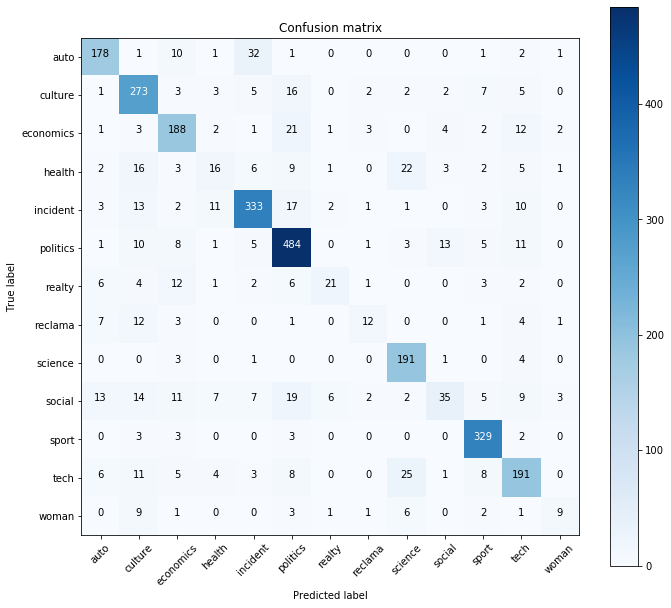

In [24]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [25]:
o = clf.predict(X)

In [26]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [27]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])

tag: politics
predict: politics
- - - - - - - - - - - - - - - - - - 

Глава ФСБ: В этом году в РФ предотвращено 42 теракта

11:05 Источник: Информационное агентство России "ТАСС"

В этом году в РФ предотвращено 42 террористических преступления, в том числе в Москве, Санкт-Петербурге, Екатеринбурге и Нижнем Новгороде. Об этом сообщил директор ФСБ Россиина совместном заседании Национального антитеррористического комитета и Федерального оперативного штаба."Повышена эффективность упреждающих действий правоохранительных органов и силовых структур. Совместными усилиями на стадии подготовки предотвращено 42 преступления террористической направленности", - сообщил он."В текущем году в Москве, Санкт-Петербурге, Екатеринбурге и Нижнем Новгороде правоохранительными органами и силовыми структурами пресечено несколько попыток совершения терактов на объектах транспорта и в местах массового пребывания людей, которые планировали выходцы из ближнего зарубежья", - отметил председатель НАК.
